### Importing the libraries

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
from minisom import MiniSom
import torch
from transformers import BertTokenizer, BertModel
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import DBSCAN
from wordcloud import WordCloud
# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.preprocessing.sequence import pad_sequences
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D
from sklearn.metrics import classification_report, accuracy_score
# import tensorflow as tf
# from tensorflow import keras
# from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split as tt
import warnings
warnings.filterwarnings('ignore')

### Reading the datasets

In [30]:
df1 = pd.read_csv("sdmn_video_details.csv")
df2 = pd.read_csv("sidemen_channels_comments.csv")
df1.rename(columns={'comments': 'number_of_comments'}, inplace=True)
df = pd.merge(df1, df2, on='video_id')
print(df.columns)

Index(['channel', 'video_id', 'title', 'description', 'categoryId',
       'publishedAt', 'duration', 'tags', 'likes', 'views',
       'number_of_comments', 'comments'],
      dtype='object')


0                              sidemen one word interview
1                             sidemen among us chaos mode
2                           sidemen association challenge
3                       sidemen noob vs pro rocket league
4       sidemen among us sheriff role the dumbest lobb...
                              ...                        
1079                           first ever sidemen podcast
1080                           sidemen manchester meet up
1081    sidemen fc vs youtube allstars charity footbal...
1082                      sidemen face painting challenge
1083                       welcome to the sidemen channel
Name: video_title, Length: 1084, dtype: object

### Functions for stemming (text pre-processing)

In [ ]:
# Stemming / Lemmatizing
words = stopwords.words("english")
port_stem = PorterStemmer()
lem = WordNetLemmatizer()

# if isinstance(df.comments.iloc[0],list):
    # print(df.comments.iloc[0])

def stemming(contents):
    contents = str(contents)
    stemmed_contents = re.sub(r'[^a-zA-Z]', ' ', contents)
    stemmed_contents = stemmed_contents.lower()
    # stemmed_contents = stemmed_contents.capitalize()
    stemmed_contents = stemmed_contents.split()
    # stemmed_contents = [port_stem.stem(word) for word in stemmed_contents if word not in words]
    # stemmed_contents = [lem.lemmatize(word) for word in stemmed_contents if word not in words]
    stemmed_contents = ' '.join(stemmed_contents)
    return stemmed_contents

def stemming_ex(contents):
    res = []
    contents = re.findall(r"'([^']*)'", contents)
    # print(len(contents))
    for content in contents:
        # print(content)
        content = str(content)
        stemmed_contents = re.sub('(@[A-Za-z0-9]+)|([^0-9A-Za-z  \t])|(\w+:\/\/\S+)', ' ', content)
        # stemmed_contents = re.sub(r'[^a-zA-Z]', ' ', contents)
        stemmed_contents = stemmed_contents.lower()
        # stemmed_contents = stemmed_contents.capitalize()
        stemmed_contents = stemmed_contents.split()
        # stemmed_contents = [port_stem.stem(word) for word in stemmed_contents if word not in words]
        # stemmed_contents = [lem.lemmatize(word) for word in stemmed_contents if word not in words]
        stemmed_contents = ' '.join(stemmed_contents)
        res.append(stemmed_contents)
        # return stemmed_contents
        # return res[0] if len(res)==1 else res
    return res


df["video_title"] = df["title"].apply(stemming)
# s = [stemming(x) for x in 
df["processed_comments"] = df["comments"].apply(stemming_ex)
# df["video_title"] = df["title"]
# print(df['video_title'])

data = list(df['video_title'])

# Convert the textual data to a vector representation using TF-IDF
# vectorizer = TfidfVectorizer()
# X = vectorizer.fit_transform(data)
# df['vectorized_data'] = list(X)
# data
df["processed_comments"]
df['video_title']

### Importing pre-trained sentiment analyser

In [31]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [35]:
# Run the polarity score on the entire dataset
res = {}
for index,video in df.iterrows():
    title = video['video_title']
    comments = video['processed_comments']
    sentiment_results = []
    for comment in comments:
        sentiment_results.append(sia.polarity_scores(comment)['compound'])
    avg_pol = sum(sentiment_results)/len(sentiment_results)
    res[title] = avg_pol

res

{'sidemen one word interview': 0.08209999999999999,
 'sidemen among us chaos mode': -0.28798,
 'sidemen association challenge': -0.06199999999999999,
 'sidemen noob vs pro rocket league': 0.11276666666666665,
 'sidemen among us sheriff role the dumbest lobby ever': 0.13018888888888888,
 'do all the sidemen think the same': 0.0032000000000000054,
 'sidemen are you smarter than a year old': 0.1493375,
 'this is the greatest sidemen video ever': 0.34574,
 'sidemen among us jester role': 0.34674444444444447,
 'sidemen extreme cop chase challenge on gta': 0.0615,
 'sidemen christmas mukbang': -0.02926666666666667,
 'sidemen secret santa': 0.14588,
 'sidemen reverse hide seek on ksi s mega yacht': 0.03242222222222223,
 'sidemen gta meme olympics': 0.2513222222222222,
 'buy christmas drillings today': -0.14691,
 'sidemen christmas drillings edm remix official music video': 0.16512222222222223,
 'sidemen box of lies': -0.0008333333333333402,
 'harry potter s doppelg nger': 0.05445,
 'sidemen c

In [37]:
polarity_df = pd.DataFrame({'video_title':list(res.keys()),'polarity_score':list(res.values())})

In [38]:
polarity_df

,video_title,polarity_score
0,sidemen one word interview,0.082100
1,sidemen among us chaos mode,-0.287980
2,sidemen association challenge,-0.062000
3,sidemen noob vs pro rocket league,0.112767
4,sidemen among us sheriff role the dumbest lobb...,0.130189
...,...,...
955,first ever sidemen podcast,-0.013000
956,sidemen manchester meet up,0.116078
957,sidemen fc vs youtube allstars charity footbal...,0.230788
958,sidemen face painting challenge,0.000000


In [39]:
senti_df = pd.merge(df, polarity_df, on='video_title', how='inner')

In [40]:
senti_df

,channel,video_id,title,description,categoryId,publishedAt,duration,tags,likes,views,number_of_comments,comments,video_title,processed_comments,polarity_score
0,MoreSidemen,g6Y6qXGH5iI,SIDEMEN ONE WORD INTERVIEW,🍗: Order food NOW at: https://www.eatsides.com...,22,2023-01-30T18:30:47Z,PT16M12S,"['sidemen', 'moresidemen', 'miniminter', 'ksi'...",144945.0,2408384.0,2291,"['ski', '15:59 that there is a violation', 'We...",sidemen one word interview,"[ski, 15 59 that there is a violation, we gott...",0.082100
1,Sidemen,zjTJ_1pv_N0,SIDEMEN ONE WORD INTERVIEW,The Sidemen are being interviewed today but ca...,24,2019-01-20T18:06:23Z,PT17M13S,"['sidemen', 'one', 'word', 'interview', 'lol']",423575.0,22155480.0,10668,"[""JJ's ForeHead Seems to be bigger than usual!...",sidemen one word interview,"[s forehead seems to be bigger than usual, , w...",0.082100
2,MoreSidemen,eQ8htMVTC8g,SIDEMEN AMONG US CHAOS MODE,FINALLY the Sidemen have created their own rol...,22,2023-01-27T18:35:30Z,PT50M48S,"['sidemen', 'moresidemen', 'miniminter', 'ksi'...",208354.0,4739125.0,5777,['What is that music between 29 and 30 minutes...,sidemen among us chaos mode,"[what is that music between 29 and 30 minutes,...",-0.287980
3,MoreSidemen,_YRHU0acMkU,SIDEMEN ASSOCIATION CHALLENGE,🍗: Order food NOW at: https://www.eatsides.com...,22,2023-01-23T18:30:26Z,PT20M19S,"['sidemen', 'moresidemen', 'miniminter', 'ksi'...",122217.0,2536436.0,2734,"['bath finally getting recognition', 'This is ...",sidemen association challenge,"[bath finally getting recognition, this is act...",-0.062000
4,MoreSidemen,sOPOoQsgoIo,SIDEMEN NOOB VS PRO ROCKET LEAGUE,🍗: Order food NOW at: https://www.eatsides.com...,22,2023-01-20T19:30:04Z,PT22M42S,"['sidemen', 'moresidemen', 'miniminter', 'ksi'...",89700.0,1871016.0,2403,"['can i play with you guys for a video pls', '...",sidemen noob vs pro rocket league,"[can i play with you guys for a video pls, vik...",0.112767
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1079,Sidemen,cTBX47Zwc80,FIRST EVER SIDEMEN PODCAST,Sidemen Book Tour: http://www.sidemenbooktour....,24,2016-09-18T14:03:25Z,PT1H1M51S,"['sidemen', 'sidemen podcast']",133642.0,4087523.0,12340,"['i hope i can make the meet ups!', '5', 'Simo...",first ever sidemen podcast,"[i hope i can make the meet ups, 5, simon stil...",-0.013000
1080,Sidemen,qvPEt52H2ZY,SIDEMEN MANCHESTER MEET UP,Sidemen Book: http://www.sidemenbook.co.uk\nSi...,24,2016-08-15T16:04:13Z,PT3M3S,"['sidemen', 'sidemen event', 'sidemen manchest...",64753.0,1272477.0,4075,"['least watched sidemen video', 'Last', 'LAST'...",sidemen manchester meet up,"[least watched sidemen video, last, last, this...",0.116078
1081,Sidemen,J_NniTO22_A,SIDEMEN FC VS YOUTUBE ALLSTARS CHARITY FOOTBAL...,DONATE HERE: https://www.justgiving.com/Sideme...,24,2016-06-03T21:45:41Z,PT2H38M45S,"['sidemen', 'sidemen charity match', 'sidemen ...",451470.0,27181272.0,36475,"[""12:40 lmao I'm not the only one that thought...",sidemen fc vs youtube allstars charity footbal...,"[m not the only one that thought it 56 30 it, ...",0.230788
1082,Sidemen,5j_fRfbscaE,SIDEMEN FACE PAINTING CHALLENGE,PREORDER SIDEMEN BOOK NOW: http://www.sidemenb...,24,2016-05-28T19:00:00Z,PT5M21S,['sidemen'],139969.0,4245986.0,16399,['In 2023 Simon and Tobi are the only ones tha...,sidemen face painting challenge,[in 2023 simon and tobi are the only ones that...,0.000000


In [42]:
sentiment = []
polarity = []
for i in senti_df.polarity_score:
    if i==0: 
        sentiment.append('neutral')
        polarity.append(0)
    elif i>0: 
        sentiment.append('positive')
        polarity.append(1)
    else:
        sentiment.append('negative')
        polarity.append(-1)
        

In [43]:
senti_df['sentiment'] = sentiment
senti_df['polarity'] = polarity

In [53]:
senti_df

,channel,video_id,title,description,categoryId,publishedAt,duration,tags,likes,views,number_of_comments,comments,video_title,processed_comments,polarity_score,sentiment,polarity,date_of_upload
0,MoreSidemen,g6Y6qXGH5iI,SIDEMEN ONE WORD INTERVIEW,🍗: Order food NOW at: https://www.eatsides.com...,22,2023-01-30T18:30:47Z,PT16M12S,"['sidemen', 'moresidemen', 'miniminter', 'ksi'...",144945.0,2408384.0,2291,"['ski', '15:59 that there is a violation', 'We...",sidemen one word interview,"[ski, 15 59 that there is a violation, we gott...",0.082100,positive,1,2023-01-30 18:30:47+00:00
1,Sidemen,zjTJ_1pv_N0,SIDEMEN ONE WORD INTERVIEW,The Sidemen are being interviewed today but ca...,24,2019-01-20T18:06:23Z,PT17M13S,"['sidemen', 'one', 'word', 'interview', 'lol']",423575.0,22155480.0,10668,"[""JJ's ForeHead Seems to be bigger than usual!...",sidemen one word interview,"[s forehead seems to be bigger than usual, , w...",0.082100,positive,1,2023-01-27 18:35:30+00:00
2,MoreSidemen,eQ8htMVTC8g,SIDEMEN AMONG US CHAOS MODE,FINALLY the Sidemen have created their own rol...,22,2023-01-27T18:35:30Z,PT50M48S,"['sidemen', 'moresidemen', 'miniminter', 'ksi'...",208354.0,4739125.0,5777,['What is that music between 29 and 30 minutes...,sidemen among us chaos mode,"[what is that music between 29 and 30 minutes,...",-0.287980,negative,-1,2023-01-23 18:30:26+00:00
3,MoreSidemen,_YRHU0acMkU,SIDEMEN ASSOCIATION CHALLENGE,🍗: Order food NOW at: https://www.eatsides.com...,22,2023-01-23T18:30:26Z,PT20M19S,"['sidemen', 'moresidemen', 'miniminter', 'ksi'...",122217.0,2536436.0,2734,"['bath finally getting recognition', 'This is ...",sidemen association challenge,"[bath finally getting recognition, this is act...",-0.062000,negative,-1,2023-01-20 19:30:04+00:00
4,MoreSidemen,sOPOoQsgoIo,SIDEMEN NOOB VS PRO ROCKET LEAGUE,🍗: Order food NOW at: https://www.eatsides.com...,22,2023-01-20T19:30:04Z,PT22M42S,"['sidemen', 'moresidemen', 'miniminter', 'ksi'...",89700.0,1871016.0,2403,"['can i play with you guys for a video pls', '...",sidemen noob vs pro rocket league,"[can i play with you guys for a video pls, vik...",0.112767,positive,1,2023-01-16 18:00:15+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1079,Sidemen,cTBX47Zwc80,FIRST EVER SIDEMEN PODCAST,Sidemen Book Tour: http://www.sidemenbooktour....,24,2016-09-18T14:03:25Z,PT1H1M51S,"['sidemen', 'sidemen podcast']",133642.0,4087523.0,12340,"['i hope i can make the meet ups!', '5', 'Simo...",first ever sidemen podcast,"[i hope i can make the meet ups, 5, simon stil...",-0.013000,negative,-1,2016-09-18 14:03:25+00:00
1080,Sidemen,qvPEt52H2ZY,SIDEMEN MANCHESTER MEET UP,Sidemen Book: http://www.sidemenbook.co.uk\nSi...,24,2016-08-15T16:04:13Z,PT3M3S,"['sidemen', 'sidemen event', 'sidemen manchest...",64753.0,1272477.0,4075,"['least watched sidemen video', 'Last', 'LAST'...",sidemen manchester meet up,"[least watched sidemen video, last, last, this...",0.116078,positive,1,2016-08-15 16:04:13+00:00
1081,Sidemen,J_NniTO22_A,SIDEMEN FC VS YOUTUBE ALLSTARS CHARITY FOOTBAL...,DONATE HERE: https://www.justgiving.com/Sideme...,24,2016-06-03T21:45:41Z,PT2H38M45S,"['sidemen', 'sidemen charity match', 'sidemen ...",451470.0,27181272.0,36475,"[""12:40 lmao I'm not the only one that thought...",sidemen fc vs youtube allstars charity footbal...,"[m not the only one that thought it 56 30 it, ...",0.230788,positive,1,2016-06-03 21:45:41+00:00
1082,Sidemen,5j_fRfbscaE,SIDEMEN FACE PAINTING CHALLENGE,PREORDER SIDEMEN BOOK NOW: http://www.sidemenb...,24,2016-05-28T19:00:00Z,PT5M21S,['sidemen'],139969.0,4245986.0,16399,['In 2023 Simon and Tobi are the only ones tha...,sidemen face painting challenge,[in 2023 simon and tobi are the only ones that...,0.000000,neutral,0,2016-05-28 19:00:00+00:00


In [75]:
senti_df['date_of_upload'] = pd.to_datetime(senti_df['publishedAt'])
senti_df.to_csv('polarity_data.csv',index=False)

### Visualization of polarity over time

In [55]:
import plotly.graph_objects as go
import plotly.express as px

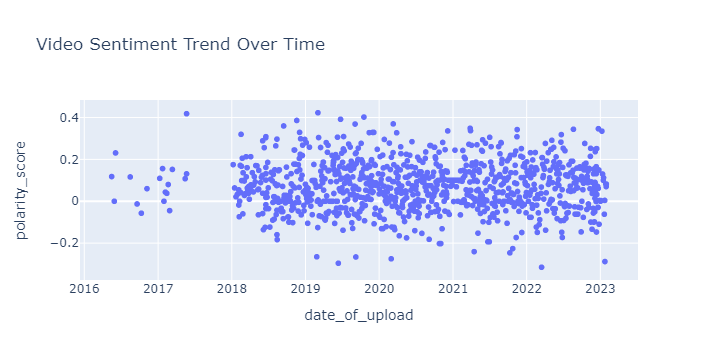

In [61]:
# Create a scatter plot with initial data (first data point)
fig = px.scatter(senti_df, x='date_of_upload', y='polarity_score', 
                 labels={'sentiment_score': 'polarity_score'},
                 title='Video Sentiment Trend Over Time',
                 hover_data=['video_title'])

# # Show the plot
fig.show()


# Understanding correlation between sentiment of users and video engagement

In [69]:
correlation = senti_df['views'].corr(senti_df['likes'])
print("Correlation between Sentiment Polarity and Likes:", correlation)

correlation = senti_df['views'].corr(senti_df['number_of_comments'])
print("Correlation between Sentiment Polarity and Likes:", correlation)

correlation = senti_df['number_of_comments'].corr(senti_df['likes'])
print("Correlation between Sentiment Polarity and Likes:", correlation)

Correlation between Sentiment Polarity and Likes: 0.8998933033719934
Correlation between Sentiment Polarity and Likes: 0.8551947017697046
Correlation between Sentiment Polarity and Likes: 0.8885819599688495


In [70]:
correlation = senti_df['polarity'].corr(senti_df['likes'])
print("Correlation between Sentiment Polarity and Likes:", correlation)

correlation = senti_df['polarity'].corr(senti_df['views'])
print("Correlation between Sentiment Polarity and Views:", correlation)

correlation = senti_df['polarity'].corr(senti_df['number_of_comments'])
print("Correlation between Sentiment Polarity and Number Of Comments:", correlation)

Correlation between Sentiment Polarity and Likes: 0.029179015964389224
Correlation between Sentiment Polarity and Views: 0.014464650504319672
Correlation between Sentiment Polarity and Number Of Comments: 0.02245067425210184


### Sentiment Polarity vs Likes

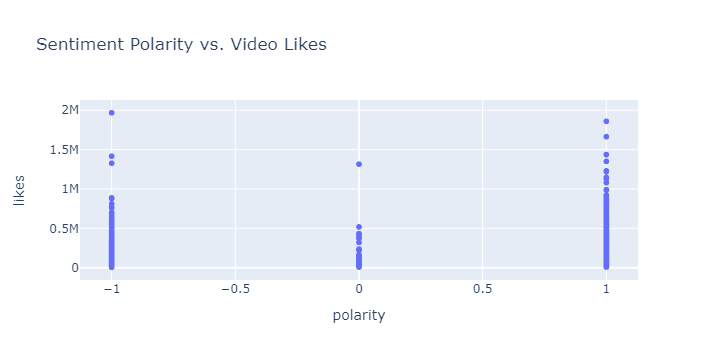

In [71]:
fig = px.scatter(senti_df, y='likes', x='polarity',
                 labels={'sentiment_score': 'polarity','Likes':'likes'},
                 title='Sentiment Polarity vs. Video Likes',
                 hover_data=['video_title'])

# Update marker properties for better visualization
fig.update_traces(marker=dict(size=12, line=dict(width=2, color='DarkSlateGrey')),
                  selector=dict(mode='markers+text'))

# Show the plot
fig.show()

## Conclusion: 
### Unfortunately there seems to be no correlation to the sentiment shared by the users to the video engagement.